<a href="https://colab.research.google.com/github/ArtyomShabunin/SMOPA/blob/main/lesson_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://prana-system.com/files/110/rds_color_full.png" alt="tot image" width="300"  align="center"/> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src="https://mpei.ru/AboutUniverse/OficialInfo/Attributes/PublishingImages/logo1.jpg" alt="mpei image" width="200" align="center"/>
<img src="https://mpei.ru/Structure/Universe/tanpe/structure/tfhe/PublishingImages/tot.png" alt="tot image" width="100"  align="center"/>

---

# **Системы машинного обучения и предиктивной аналитики в тепловой и возобновляемой энергетике**  

# ***Практические занятия***


---

# Занятие №9
# Прогнозирование временных рядов методами глубокого обучения
**9 апреля 2025г.**

---

Задачу прогнозирования временных рядов можно эффективно решать методами глубокого обучения, особенно когда данные содержат нелинейные зависимости, сезонность или сложную динамику. Вот основные подходы и архитектуры, которые используются:

---

### 1. **Рекуррентные нейронные сети (RNN)**
Используются для последовательной обработки данных.

- **Vanilla RNN** — базовая форма RNN, редко используется из-за проблем исчезающего градиента.
- **LSTM (Long Short-Term Memory)** — популярный выбор, хорошо справляется с долговременными зависимостями.
- **GRU (Gated Recurrent Unit)** — упрощённая версия LSTM, быстрее обучается и требует меньше вычислений.

**Пример использования:**  
Вход: последовательность значений временного ряда  
Выход: значение (или несколько) на следующем шаге  

---

### 2. **1D-Сверточные сети (CNN для временных рядов)**
Могут извлекать локальные шаблоны в данных.

- Эффективны для коротких зависимостей и быстрых расчётов.
- Часто используются в комбинации с RNN/LSTM (например, CNN+LSTM).

---

### 3. **Encoder-Decoder архитектуры**
Подход из области машинного перевода, адаптированный к временным рядам:

- **Encoder** считывает входную последовательность.
- **Decoder** генерирует выходную последовательность (будущие значения).

---

### 4. **Transformer и его модификации**
Модель, изначально разработанная для NLP, показала себя отлично и в задаче прогнозирования временных рядов.

- **Informer, Autoformer, Transformer-XL, TimesNet** — специализированные архитектуры для временных рядов.
- Transformer позволяет учитывать долгосрочные зависимости благодаря механизмам внимания.

---

### 5. **Сети прямого распространения (MLP)**
Простые полносвязные сети можно применять, если на вход подаются фичи из скользящего окна (например, 10 предыдущих точек). Хорошо работают при небольшой сложности данных.

---

### 6. **Гибридные подходы**
Комбинации из разных типов сетей:
- **CNN+LSTM**
- **Encoder (CNN/LSTM) + Attention + Decoder**
- **Transformer + Residual MLP**

---

### Как строится вход для модели:
- **Скользящее окно**: берём последние `n` точек временного ряда как вход, предсказываем следующие `m` точек.
- Можно добавлять фичи:
  - Временные метки (час, день недели, месяц)
  - Внешние воздействия (управляющие сигналы, температура воздуха и т.д.)


In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", rc={'figure.figsize':(15,6)})

import numpy as np
import pandas as pd
from sklearn import preprocessing
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import lr_scheduler

from tqdm import tqdm

## Загрузка данных
Набор содержит данные о почасовом производстве ветряной и солнечной электроэнергии (в МВт) во французской электросети с 2020 года.

In [2]:
import gdown
import warnings
warnings.filterwarnings('ignore')
gdown.download('https://drive.google.com/uc?id=1NAYPaEkovk7jvaURdjI0nCi7CUMxry7W', verify=False)

df = pd.read_csv('./intermittent-renewables-production-france.csv')

Downloading...
From: https://drive.google.com/uc?id=1NAYPaEkovk7jvaURdjI0nCi7CUMxry7W
To: /content/intermittent-renewables-production-france.csv
100%|██████████| 5.12M/5.12M [00:00<00:00, 43.6MB/s]


In [3]:
df = pd.read_csv('intermittent-renewables-production-france.csv')
df = df.rename(columns={'Date and Hour' : 'DateTime'})
df['DateTime'] = df['DateTime'].str.slice(stop=-6)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values(ascending=True,by='DateTime')
df = df.drop(['Date','dayOfYear','dayName','monthName'],axis=1)
df = df.dropna()
df = df.set_index("DateTime")

In [4]:
solar = df[df['Source'] == 'Solar']['Production']
wind = df[df['Source'] == 'Wind']['Production']

In [5]:
solar.head()

,Production
DateTime,
2020-01-01 00:00:00,0.0
2020-01-01 01:00:00,0.0
2020-01-01 02:00:00,0.0
2020-01-01 03:00:00,0.0
2020-01-01 04:00:00,0.0


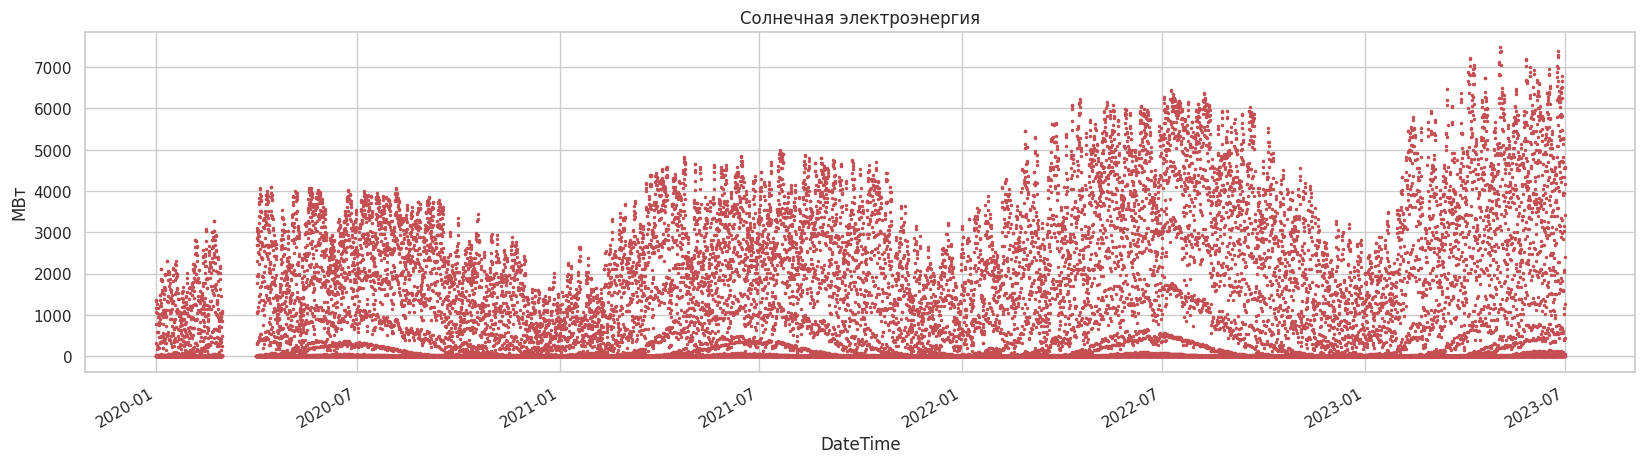

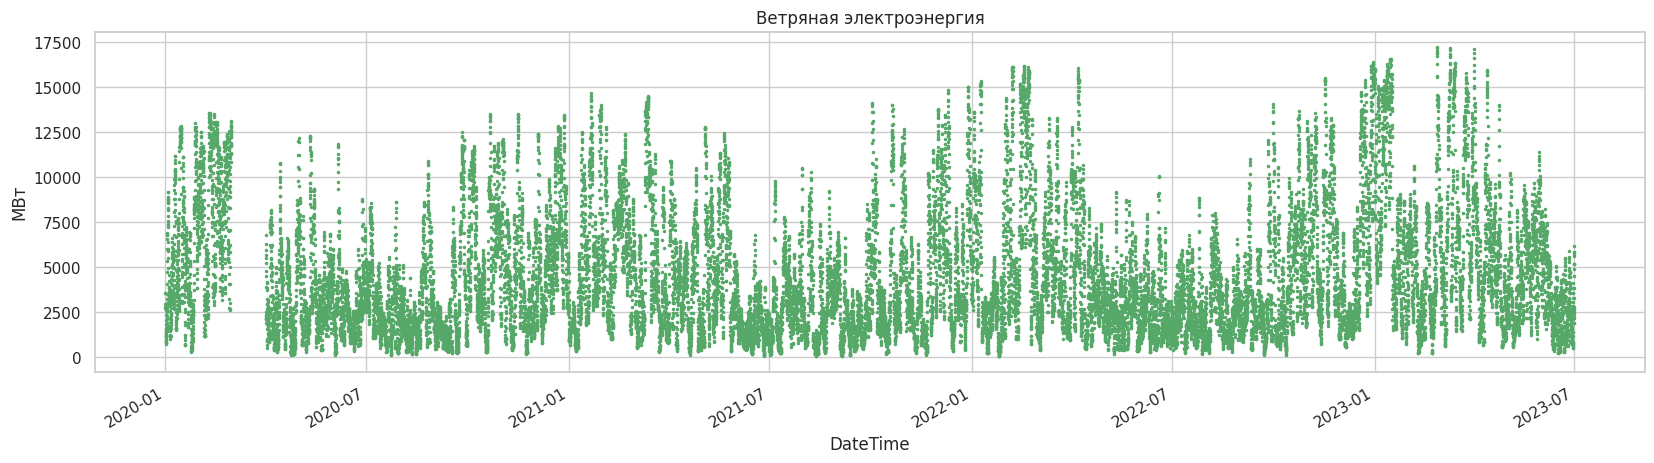

In [6]:
color_pal = sns.color_palette()
solar.plot(style='.',
          figsize=(20, 5),
          ms=3,
          color=color_pal[3],
          title='Солнечная электроэнергия')
plt.ylabel("МВт")
plt.show()

wind.plot(style='.',
          figsize=(20, 5),
          ms=3,
          color=color_pal[2],
          title='Ветряная электроэнергия')
plt.ylabel("МВт")
plt.show()

## Сформируем датасет на основе данных о производстве солнечной электроэнергии
### Разделим данные на обучающую и тестовую выборки

In [7]:
cutoff_date = '2023-01-01'

solar_train = solar[solar.index < cutoff_date].copy()
solar_test = solar[solar.index >= cutoff_date].copy()

print(f"Train: {solar_train.shape[0]} записей")
print(f"Test: {solar_test.shape[0]} записей")

Train: 25558 записей
Test: 4343 записей


### Нормализация или стандартизация данных

In [9]:
solar_scaler = preprocessing.MinMaxScaler() # нормализация данных
# solar_scaler = preprocessing.StandardScaler() # стандартизация данных

solar_train_scaled = pd.DataFrame(
    solar_scaler.fit_transform(solar_train.values[:, None]),
    index=solar_train.index)

solar_test_scaled = pd.DataFrame(
    solar_scaler.transform(solar_test.values[:, None]),
    index=solar_test.index)

solar_train_scaled.describe()

,0
count,25558.000000
mean,0.155712
std,0.225198
min,0.000000
25%,0.000155
50%,0.005895
75%,0.280329
max,1.000000


### Dataset и DataLoader

In [10]:
class SolarDataset(Dataset):
    def __init__(self, data, n_lags, horizon):
        self.n_lags = n_lags
        self.horizon = horizon
        data = data.reshape(-1)
        self.x = torch.tensor(data[:-self.horizon], dtype=torch.float32)
        self.y = torch.tensor(data[self.n_lags:],dtype=torch.float32)

    def __getitem__(self, idx):
        return self.x[idx:idx+self.n_lags], self.y[idx:idx+self.horizon]

    def __len__(self):
        return self.y.shape[0]-self.horizon+1

In [11]:
N_LAGS = 10
HORIZON = 100
HIDDEN_DIM = 1024
HIDDEN_NUM = 2

solar_dataset = SolarDataset(solar_train_scaled.values, N_LAGS, HORIZON)

In [12]:
solar_train_size = int(0.8 * len(solar_dataset))
solar_valid_size = len(solar_dataset) - solar_train_size

solar_train_dataset = Subset(solar_dataset, range(solar_train_size))
solar_valid_dataset = Subset(
    solar_dataset, range(solar_train_size, solar_train_size + solar_valid_size))

batch_size = 256

solar_train_loader = DataLoader(solar_train_dataset, batch_size=batch_size, shuffle=True)
solar_valid_loader = DataLoader(solar_valid_dataset, batch_size=batch_size, shuffle=True)

## Предсказание производства солнечной электроэнергии
### Полносвязная нейронная сеть (многослойный персептрон)

In [13]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, hidden_num=1):
        super(FeedForwardNN, self).__init__()
        self.hidden_num = hidden_num
        self.linear = nn.ModuleList()
        for i in range(self.hidden_num):
            if i == 0:
              self.linear.append(nn.Linear(input_dim, hidden_dim))
            else:
              self.linear.append(nn.Linear(hidden_dim, hidden_dim))
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        for i in range(self.hidden_num):
            x = F.relu(self.linear[i](x))
        result = self.out(x)
        return result

In [14]:
model = FeedForwardNN(input_dim=N_LAGS,
                      hidden_dim=HIDDEN_DIM,
                      output_dim=HORIZON,
                      hidden_num=HIDDEN_NUM)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=3, threshold=0.0001)

epochs = 100

In [15]:
train_losses = []
test_losses = []

loaders = {"train": solar_train_loader, "valid": solar_valid_loader}
losses = {"train": [], "valid": []}
lr = []

for epoch in tqdm(range(epochs)):

    for k, dataloader in loaders.items():
        running_loss = []

        for x_batch, y_batch in dataloader:

                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    out = model(x_batch)

                else:
                    model.eval()
                    with torch.no_grad():
                        out = model(x_batch)

                loss = loss_fn(out, y_batch)
                running_loss.append(loss.item())

                if k == "train":
                    loss.backward()
                    optimizer.step()

        losses[k].append(np.array(running_loss).mean())
    lr.append(scheduler.get_last_lr())
    scheduler.step(losses["train"][-1])

100%|██████████| 100/100 [09:46<00:00,  5.86s/it]


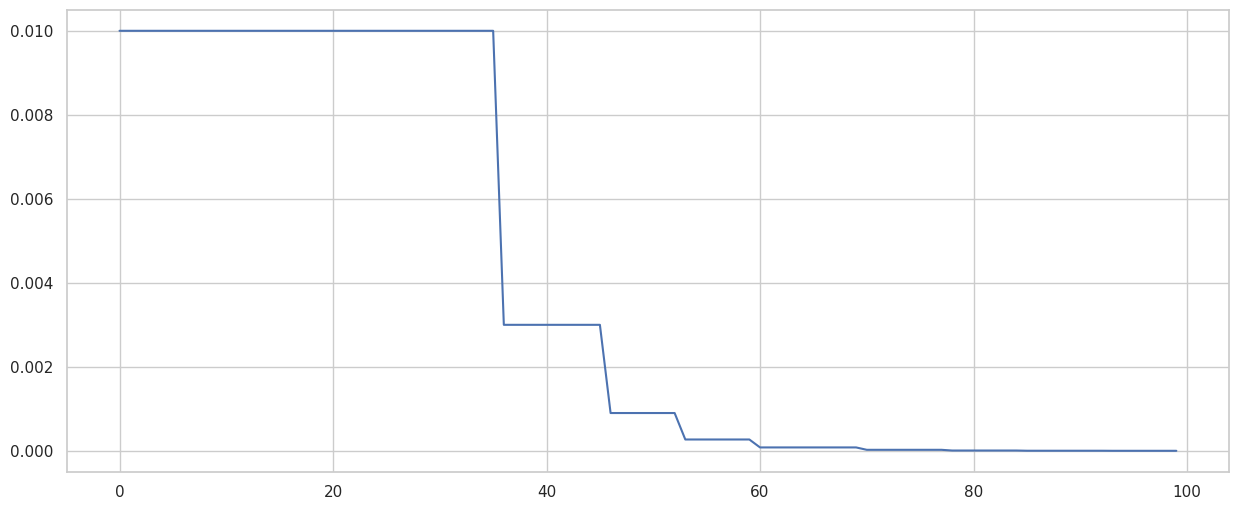

In [16]:
plt.plot(lr);

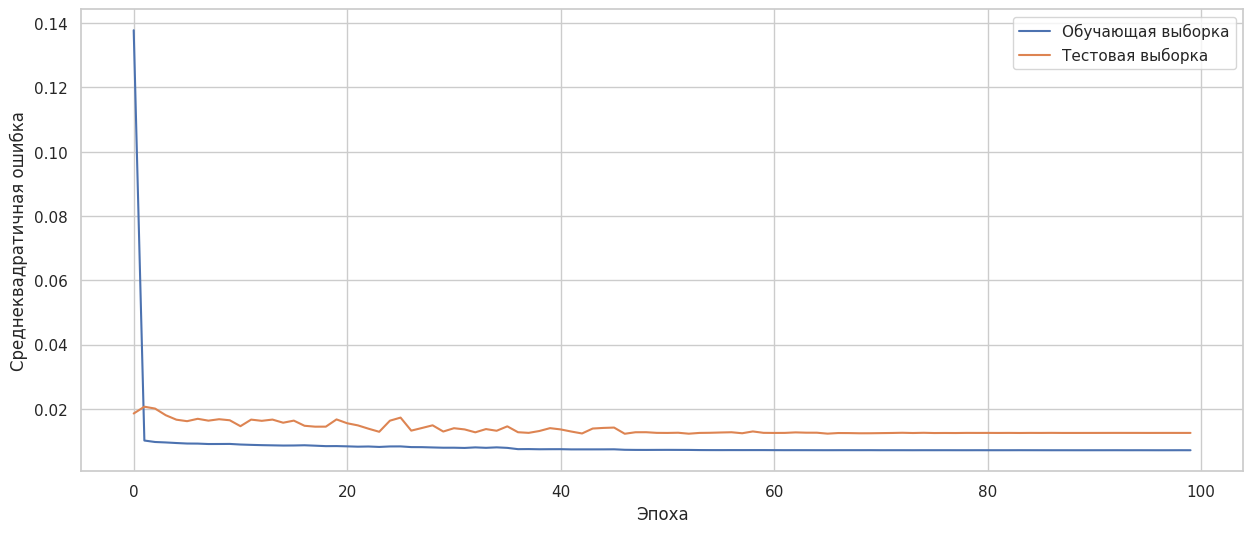

In [17]:
plt.plot(losses["train"], label="Обучающая выборка");
plt.plot(losses["valid"], label="Тестовая выборка");
plt.legend();
plt.xlabel("Эпоха");
plt.ylabel("Среднеквадратичная ошибка");

In [19]:
print(f"Минимальный loss на тренировочной выборке: {min(losses['train']):.2f}")
print(f"Минимальный loss на валидационной выборке: {min(losses['valid']):.2f}")

Минимальный loss на тренировочной выборке: 0.01
Минимальный loss на валидационной выборке: 0.01


In [25]:
solar_test.values[start:start+N_LAGS]

array([  1.,   1.,   1.,   1.,   0.,   1.,   1.,   1.,  29., 422.])

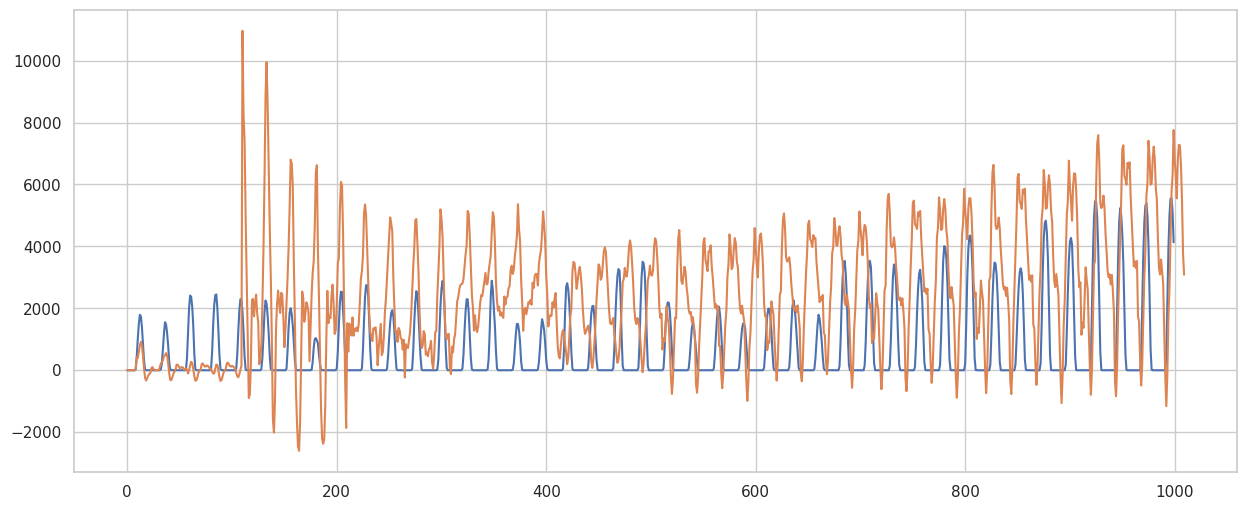

In [27]:
start = 0
predicted_steps = 10
in_data = solar_test.values[start:start+N_LAGS].reshape(-1)
for i in range(predicted_steps):
    out_data = model(torch.tensor(in_data[-N_LAGS:], dtype=torch.float32))
    in_data = np.concatenate((in_data, out_data.detach().numpy()))

plt.plot(solar_test.values[start:start+predicted_steps*HORIZON])
plt.plot(in_data);